<a href="https://colab.research.google.com/github/mnasim99/CV-A2/blob/main/CV_A2_VGGBase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Loading dataset**

In [2]:
import cv2
import numpy as np
import os
from google.colab.patches import cv2_imshow


In [3]:
from google.colab import drive

#mounting drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
#extracting training data
data = !tar -xvf "drive/My Drive/Colab Notebooks/CV-A2/train_and_val_set.tar"

In [5]:
#extracting test data
data_test = !tar -xvf "drive/My Drive/Colab Notebooks/CV-A2/test_set.tar"

In [ ]:

# counting total number of images in training directory

dir_path = r'train_set/images'
count_img = 0
# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        count_img += 1
print('File count:', count_img)

File count: 287651


In [ ]:
# Storing indices of images for further usage

indices=[]
dir_path = r'train_set/images'

for path in os.listdir(dir_path):
  indices.append(path)
      #print(path)
      #a=path.split(".")[0]
      #print(a)

In [ ]:
len(indices)

287651

In [ ]:
#taking only 50,000 images and resizing them later because of limited RAM. Code was crashing while training for complete dataset

indices=indices[:50000]
selected_images=np.asarray(indices)
np.savetxt('images.csv', selected_images, delimiter=',',fmt = '%s')

## Preprocesssing data 
Combining each image with its corresponding labels

In [6]:
def training_dataset():

  train_images=[]
  train_annotations=[]
 
  for images in indices:
        images=str(images)
        img_name=images[:-4]+'_'
        img=cv2.imread('/content/train_set/images/'+images)
        img=cv2.resize(img,(100,100))
        train_images.append(img) 
        
        #Storing all annotations in one array
        annotate=np.array([np.load('/content/train_set/annotations/'+img_name+'aro.npy'),
                           np.load('/content/train_set/annotations/'+img_name+'lnd.npy'),
                           np.load('/content/train_set/annotations/'+img_name+'val.npy'),
                           np.load('/content/train_set/annotations/'+img_name+'exp.npy')])
        train_annotations.append(annotate)

  return train_images,train_annotations



In [7]:

def test_dataset():

  val_images=[]
  val_annotations=[]
  
  for images in os.listdir('/content/val_set/images'):
        img_name=images[:-4]+'_'
        img=cv2.imread('/content/val_set/images/'+images)
        img=cv2.resize(img,(100,100))
        val_images.append(img) 

        #Storing all annotations in one array
        annotate=np.array([np.load('/content/val_set/annotations/'+img_name+'aro.npy'),
                           np.load('/content/val_set/annotations/'+img_name+'lnd.npy'),
                           np.load('/content/val_set/annotations/'+img_name+'val.npy'),
                           np.load('/content/val_set/annotations/'+img_name+'exp.npy')])
        val_annotations.append(annotate) 

  return val_images,val_annotations

In [9]:
# loading training data
train_images,train_annotations=training_dataset()


<ipython-input-6-704062b30c52>:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  annotate=np.array([np.load('/content/train_set/annotations/'+img_name+'aro.npy'),


## Splitting into training and validation

In [10]:
def Split_data(train_images,train_annotations):
 
  #80-20 Ratio split
  X_train, y_train, X_val, y_val = train_test_split(train_images, train_annotations, test_size=0.2, random_state=1,shuffle=True)
  
  X_train=np.asarray(X_train)
  y_train=np.asarray(y_train)
  X_val=np.asarray(X_val)
  y_val=np.asarray(y_val)

  #Normalization
  X_train=X_train/255.0
  y_train=y_train/255.0

  # extracting expression,aro and val value for train samples
  train_labels=np.asarray(X_val[:,3])
  train_val=np.asarray(X_val[:,2])
  train_aro=np.asarray(X_val[:,0])

  # extracting expression,aro and val value for validation samples
  val_labels=np.asarray(y_val[:,3])
  val_val=np.asarray(y_val[:,2])
  val_aro=np.asarray(y_val[:,0])

  #Converting values tofloat
  train_val = np.array([np.array(float(val)) for val in train_val])
  val_val = np.array([np.array(float(val)) for val in val_val])
  train_aro = np.array([np.array(float(val)) for val in train_aro])
  val_aro = np.array([np.array(float(val)) for val in val_aro])

  return X_train,train_labels,train_val,train_aro, y_train, val_labels, val_val,val_aro


In [11]:
from sklearn.model_selection import train_test_split

X_train,train_labels,train_val,train_aro, y_train, val_labels, val_val,val_aro=Split_data(train_images,train_annotations)


# **Model**

### Baseline- VGG16

In [12]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 9.6 MB/s eta 0:00:00


In [13]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16,EfficientNetV2L,ResNet50,ResNet101
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
from matplotlib import pyplot as plt
import tensorflow_addons as tfa


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [14]:
def VGG_custom_network():
  
  # using pretrained VGG16 
  base_model = tf.keras.applications.VGG16(weights='imagenet', input_shape=(100,100,3),classes=8,include_top=False) 

  base_model.trainable = False

  inputs=tf.keras.Input(shape=(100,100,3))

  x = base_model(inputs, training=False)
  
  output=(tf.keras.layers.Flatten())(x)
 

  #last three layers, one for classification and two for regression
  labels=(tf.keras.layers.Dense(8, activation=tf.keras.activations.softmax))(output)
  val=(tf.keras.layers.Dense(1, activation="linear"))(labels)
  aro=(tf.keras.layers.Dense(1, activation="linear"))(labels)
  
  #final model
  model=tf.keras.Model(inputs=inputs, outputs=[labels,val,aro])

  return model


  

In [15]:
def make_model():

  #initializing model
  model=VGG_custom_network()

  # optimizer
  opt = tf.keras.optimizers.Adam(learning_rate=0.01)


  # using categorical crossentropy loss for multi class classification and using mean square error for continuous domain
  model.compile(optimizer=opt, 
              loss=["categorical_crossentropy","mse","mse"],
              metrics=["accuracy","mse"])

  return model

In [16]:
model=make_model()

58889256/58889256 [==============================] - 3s 0us/step


In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, 3, 3, 512)    14714688    ['input_2[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 4608)         0           ['vgg16[0][0]']                  
                                                                                                  
 dense (Dense)                  (None, 8)            36872       ['flatten[0][0]']            

In [18]:
def encoding(train_labels,val_labels):
    # converting expression labels
    X_val = to_categorical(train_labels)
    y_val = to_categorical(val_labels)
    
    return X_val,y_val

In [24]:
def train_model(model,X_train,X_val,train_val,train_aro,y_train,y_val,val_val,val_aro): 
  output=model.fit(x=X_train,y=[X_val,train_val,train_aro],batch_size=32,epochs=15,verbose=1,validation_data=(y_train,[y_val,val_val,val_aro]))
  return output

In [22]:
#preparing labels
X_val,y_val=encoding(train_labels,val_labels)

In [25]:
resulting=train_model(model,X_train,X_val,train_val,train_aro,y_train,y_val,val_val,val_aro)

Epoch 1/15
363/363 [==============================] - 20s 54ms/step - loss: 1.0006 - dense_loss: 0.8318 - dense_1_loss: 0.1058 - dense_2_loss: 0.0630 - dense_accuracy: 0.7146 - dense_mse: 0.0523 - dense_1_accuracy: 0.0346 - dense_1_mse: 0.1058 - dense_2_accuracy: 0.0340 - dense_2_mse: 0.0630 - val_loss: 2.2380 - val_dense_loss: 1.9656 - val_dense_1_loss: 0.1820 - val_dense_2_loss: 0.0903 - val_dense_accuracy: 0.5227 - val_dense_mse: 0.0939 - val_dense_1_accuracy: 0.0368 - val_dense_1_mse: 0.1820 - val_dense_2_accuracy: 0.0465 - val_dense_2_mse: 0.0903
Epoch 2/15
363/363 [==============================] - 19s 54ms/step - loss: 0.9955 - dense_loss: 0.8279 - dense_1_loss: 0.1047 - dense_2_loss: 0.0629 - dense_accuracy: 0.7164 - dense_mse: 0.0523 - dense_1_accuracy: 0.0346 - dense_1_mse: 0.1047 - dense_2_accuracy: 0.0340 - dense_2_mse: 0.0629 - val_loss: 2.2604 - val_dense_loss: 1.9867 - val_dense_1_loss: 0.1816 - val_dense_2_loss: 0.0921 - val_dense_accuracy: 0.5537 - val_dense_mse: 0.089

# **Results**

### Label accuracy

In [42]:
def plot_class_result():
  epochs = range(0,15)
  train_acc = resulting.history['dense_accuracy']
  val_acc = resulting.history['val_dense_accuracy']


  plt.plot(epochs, train_acc, 'r',label="train")
  plt.plot(epochs, val_acc, 'black',label="val")
  plt.title('Training and Validation accuracy for labels')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

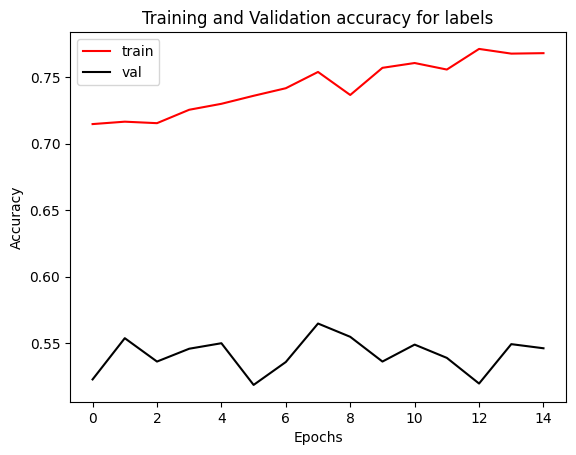

In [43]:
plot_class_result()

### Valence mse

In [37]:
def plot_val():
  epochs = range(0,15)
  val_mse_train = resulting.history['dense_1_mse']
  val_mse = resulting.history['val_dense_1_mse']

  plt.plot(epochs, val_mse_train, 'r',label="train")
  plt.plot(epochs, val_mse, 'black',label="val")
  plt.title('Training and Validation MSE')
  plt.xlabel('Epochs')
  plt.ylabel('MSE')
  plt.legend()
  plt.show()

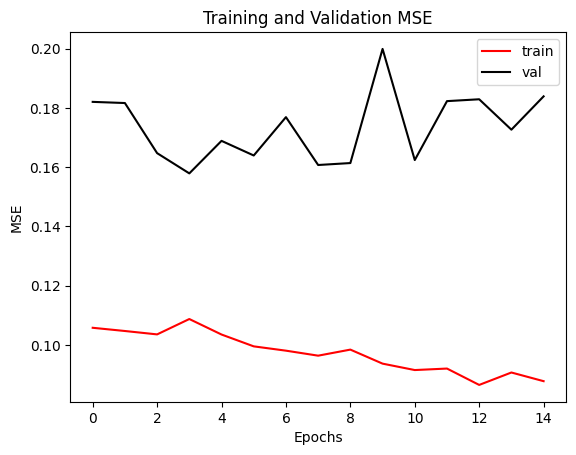

In [38]:
plot_val()

### Arousal MSE


In [39]:
def plot_aro():
  epochs = range(0,15)
  aro_mse_train = resulting.history['dense_2_mse']
  aro_mse = resulting.history['val_dense_2_mse']

  plt.plot(epochs, aro_mse_train, 'r',label="train")
  plt.plot(epochs, aro_mse, 'black',label="val")
  plt.title('Training and Validation MSE for arousal')
  plt.xlabel('Epochs')
  plt.ylabel('MSE')
  plt.legend()
  plt.show()

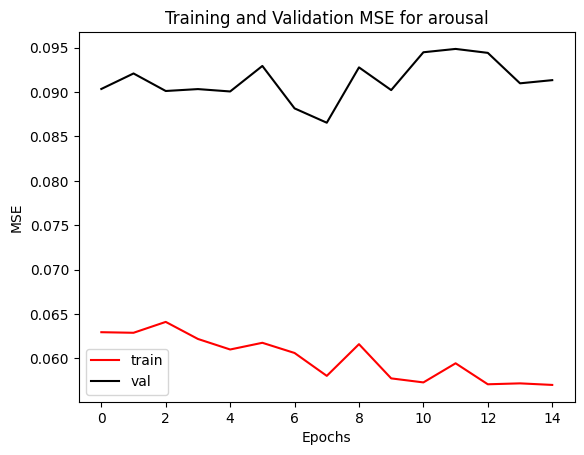

In [40]:
plot_aro()

# **Quantitative Results**

In [47]:
def classification_metrics(pred_labels,test_labels):

  results=np.argmax(pred_labels,axis=1)
  actual_values=np.argmax(test_labels,axis=1)

  #f1 score
  f1score=tfa.metrics.F1Score(num_classes=8, threshold=0.5)
  f1score.update_state(pred_labels, test_labels)
    
  #ROC curve
  AUC=tf.keras.metrics.AUC(curve='ROC')
  AUC.update_state(pred_labels, test_labels)
  
  # cohens kappa
  kappa=tfa.metrics.CohenKappa(num_classes=8)
  kappa.update_state(pred_labels, test_labels)
  
  # Area under the Precision recall  curve
  AUC_PR=tf.keras.metrics.AUC(curve='PR')
  AUC_PR.update_state(pred_labels, test_labels)

  
  # Accuracy
  T=0
  F=0
  for i in range(0,len(results)):
    if(results[i]==actual_values[i]):
      T+=1
    else:
      F+=1
      
  print("Accuracy: ",T/(T+F),"\n")
  print("F1 score: ", f1score.result(),"\n")
  print("kappa: ",kappa.result(),"\n")
  print("AUC: ",AUC.result(),"\n")
  print("AUC PR: ",AUC_PR.result(),"\n")


In [51]:
def continuous_metrics(pred,test):

  #Root mean square
  rms=tf.keras.metrics.RootMeanSquaredError()
  rms.update_state(pred, test)

  # Correlation
  pred_cov=pred.reshape((pred.shape[0],))
 
  #CCC 
  sxy = np.sum((pred_cov - pred_cov.mean())*(test - test.mean()))/pred_cov.shape[0]
  rhoc = 2*sxy / (np.var(pred_cov) + np.var(test) + (pred_cov.mean() - test.mean())**2)
  

  print("Root mean squared error: ", rms.result(),"\n")
  print("correlation: ",np.corrcoef(pred_cov,test)[0,1],"\n")
  print("CCC: ", rhoc)

In [49]:
#loading test data
test_images,test_annotations=test_dataset()

#preprocessing test data
test_images=np.asarray(test_images)
test_annotations=np.asarray(test_annotations)
test_labels=np.asarray(test_annotations[:,3])
test_aro=np.asarray(test_annotations[:,0])
test_val=np.asarray(test_annotations[:,2])
test_val = np.array([np.array(float(val)) for val in test_val])
test_aro = np.array([np.array(float(val)) for val in test_aro])

#normalizing test images
test_images=test_images/255.0

# performing one hot encoding
test_labels = to_categorical(test_labels)

# predicting labels,valence and arousal on test data
pred_labels,pre_valence,pred_aro=model.predict(test_images)


print("Results for expression labels")
classification_metrics(pred_labels,test_labels)



<ipython-input-7-4fbdc58b1c43>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  annotate=np.array([np.load('/content/val_set/annotations/'+img_name+'aro.npy'),


125/125 [==============================] - 4s 34ms/step
Results for expression labels
Accuracy:  0.23455863965991497 

F1 score:  tf.Tensor(
[2.7181461e-01 3.9327931e-01 9.3047886e-20 2.4589818e-21 1.6254246e-20
 3.0417904e-01 2.5985235e-19 3.0461857e-01], shape=(8,), dtype=float32) 

kappa:  tf.Tensor(0.12521237, shape=(), dtype=float32) 

AUC:  tf.Tensor(0.47007072, shape=(), dtype=float32) 

AUC PR:  tf.Tensor(0.99536115, shape=(), dtype=float32) 



In [52]:
print("Results for Valence")
continuous_metrics(pre_valence,test_val)


Results for Valence
Root mean squared error:  tf.Tensor(0.5081417, shape=(), dtype=float32) 

correlation:  0.26388691813989484 

CCC:  0.2406824427099492


In [53]:
print("Results for Arousal")
continuous_metrics(pred_aro,test_aro)

Results for Arousal
Root mean squared error:  tf.Tensor(0.42576838, shape=(), dtype=float32) 

correlation:  0.0183377900319583 

CCC:  0.013331612644757644


# **Qualitative Results**

Correctly Classified: 


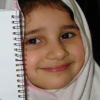

Correct label 1
Predicted label 1




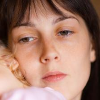

Correct label 0
Predicted label 0




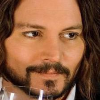

Correct label 0
Predicted label 0




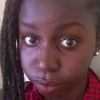

Correct label 0
Predicted label 0




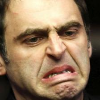

Correct label 5
Predicted label 5




In [55]:
correct=[]
cr_label=[]
wrong=[]
wr_label=[]
pred_cr=[]
pred_wr=[]
results=np.argmax(pred_labels,axis=1)
actual_values=np.argmax(test_labels,axis=1)
  
for i in range(0,len(results)):
  if(results[i]==actual_values[i]):
     correct.append(test_images[i])
     cr_label.append(results[i])
     pred_cr.append(actual_values[i])
  else:
     wrong.append(test_images[i])
     wr_label.append(results[i])
     pred_wr.append(actual_values[i])
 
print("Correctly Classified: ")
for i in range(0,5):
  cv2_imshow(correct[i]*255)
  print("Correct label", cr_label[i])
  print("Predicted label", pred_cr[i])
  print("\n")
 


Incorrectly Classified: 


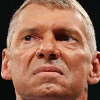

Correct label 0
Predicted label 5




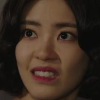

Correct label 1
Predicted label 5




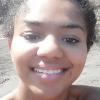

Correct label 7
Predicted label 1




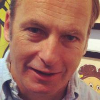

Correct label 0
Predicted label 6




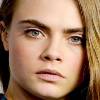

Correct label 7
Predicted label 3




In [56]:
print("Incorrectly Classified: ")
for i in range(0,5):
  cv2_imshow(wrong[i]*255)
  print("Correct label",wr_label[i])
  print("Predicted label",pred_wr[i])
  print("\n")